In [1]:
#only for kaggle
!conda install -y gdown

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.14.0            |     pyhd8ed1ab_0          16 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be 

In [2]:
!gdown --id 1mOMQcc7CtbNAYQZLd81Nfy_BG9hCK2ui

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mOMQcc7CtbNAYQZLd81Nfy_BG9hCK2ui
From (redirected): https://drive.google.com/uc?id=1mOMQcc7CtbNAYQZLd81Nfy_BG9hCK2ui&confirm=t&uuid=bdc7ceb5-c632-43c9-92b1-d368e71a9d45
To: /kaggle/working/IRMAS-TrainingData.zip
100%|██████████████████████████████████████| 3.18G/3.18G [00:40<00:00, 78.2MB/s]


In [ ]:
!unzip IRMAS.zip -d /working

In [4]:
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import f1_score, roc_curve, precision_score, roc_auc_score, confusion_matrix
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.parameter import Parameter
from torchvision import models
import torchaudio as ta
import copy
import os

from scipy.special import logit, expit

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
classes_path = "/working/IRMAS/"
classes = os.listdir(classes_path)

train_dict = {'path': [], 'target':[]}

for inst in classes:
    files_path = classes_path + inst + "/"
    if inst[0] != 'R':
        files = os.listdir(files_path)
        train_dict['path'].extend(["/working/IRMAS-TrainingData/" + inst + "/" + file for file in files])
        train_dict['target'].extend([inst] * len(files))
    
df = pd.DataFrame(train_dict)
df.head()

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_dict['path'],train_dict['target'], test_size=0.20, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.125, random_state=42, shuffle=True)

test_df = pd.DataFrame({'path': x_test, 'target': y_test})
train_df = pd.DataFrame({'path': x_train, 'target': y_train})
val_df = pd.DataFrame({'path': x_val, 'target': y_val})

In [7]:
SR = 44100

len_audio = 3.0
n_mels = 128
fmin = 20
fmax = 16000
n_fft = 1024
hop_length = 512
GRADIENT_ACCUMULATION = 1
NFOLDS = 5

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
epochs = 15
batch_size = 32
batch_size_val = 64

In [8]:
INS_CODE = {}
INV_INS_CODE = {}
for i,label in enumerate(sorted(df.target.unique())):
    INS_CODE[label] = i
    INV_INS_CODE[i] = label

In [9]:
def get_audio(path,sr=SR):
    y, sample_rate = librosa.load(path, sr=sr)
    return y

def mono_to_color(X, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)
    
    mean = X.mean()
    std = X.std()
    X = (X - mean) / (std + eps)
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def normalize(image, mean=None, std=None):
    image = image / 255.0
    return np.moveaxis(image, 2, 0).astype(np.float32)

def compute_melspec(y):
    melspec = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=n_mels, fmin=fmin, fmax=fmax, n_fft=n_fft, hop_length=hop_length
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

In [10]:
class MusicDataset(Dataset):
    def __init__(self, data, test=False):
        super(MusicDataset, self).__init__()
        self.data = data
        self.test = test
        self.effective_length = int(SR * len_audio)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx: int):
        sample = self.data.loc[idx]

        waveform = get_audio(sample['path'])
    

        if len(waveform) > self.effective_length:
            waveform = waveform[:int(SR * len_audio)]
        else:
            new_wave = np.zeros(self.effective_length, dtype=waveform.dtype)
            start = np.random.randint(self.effective_length - len(waveform))
            new_wave[start:start + len(waveform)] = waveform
            waveform = new_wave.astype(np.float32)
        
        melspec = compute_melspec(waveform)
        image = mono_to_color(melspec)
        image = normalize(image)
        
        targets = INS_CODE[sample['target']]    
        return image, targets


In [ ]:
class MusicDetectionNet(nn.Module):
    def __init__(self, out_dim):
        super(MusicDetectionNet, self).__init__()
        self.out_dim = out_dim
        self.vgg16 = models.vgg16(pretrained=True)
        self.num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(self.num_features, self.out_dim)
    
    def forward(self, x):
        return self.vgg16(x)

In [ ]:
train_dataset = MusicDataset(pd.DataFrame({'path': x_train, 'target':y_train}))
val_dataset = MusicDataset(pd.DataFrame({'path': x_val, 'target':y_val}))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

test_set = MusicDataset(test_df)
test_loader =  DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
# model = Net(11).to(device)
model = MusicDetectionNet(11).to(device)

In [23]:
dataloader = {
    'train':train_loader,
    'val':val_loader
}
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [24]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=20):
    start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0
            for x_batch, y_batch in dataloaders[phase]:
                inputs, labels = x_batch, y_batch
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history, train_loss_history, val_loss_history

In [25]:
model, val_acc_history, train_loss_history, val_loss_history = train_model(model, dataloader, optimizer, criterion, 20)

Epoch 0/19
----------
train Loss: 1.7684 Acc: 0.3916
val Loss: 1.2709 Acc: 0.5693
Epoch 1/19
----------
train Loss: 1.1711 Acc: 0.6096
val Loss: 1.1179 Acc: 0.6244
Epoch 2/19
----------
train Loss: 0.8740 Acc: 0.7128
val Loss: 1.0999 Acc: 0.6632
Epoch 3/19
----------
train Loss: 0.7027 Acc: 0.7733
val Loss: 0.9443 Acc: 0.7004
Epoch 4/19
----------
train Loss: 0.5391 Acc: 0.8240
val Loss: 0.8811 Acc: 0.7377
Epoch 5/19
----------
train Loss: 0.3787 Acc: 0.8773
val Loss: 0.8360 Acc: 0.7437
Epoch 6/19
----------
train Loss: 0.2888 Acc: 0.9011
val Loss: 0.8923 Acc: 0.7377
Epoch 7/19
----------
train Loss: 0.1901 Acc: 0.9405
val Loss: 1.1009 Acc: 0.7377
Epoch 8/19
----------
train Loss: 0.1772 Acc: 0.9412
val Loss: 0.9422 Acc: 0.7586
Epoch 9/19
----------
train Loss: 0.1148 Acc: 0.9646
val Loss: 1.0302 Acc: 0.7332
Epoch 10/19
----------
train Loss: 0.1644 Acc: 0.9510
val Loss: 0.8671 Acc: 0.7824
Epoch 11/19
----------
train Loss: 0.1340 Acc: 0.9599
val Loss: 0.9840 Acc: 0.7571
Epoch 12/19
--

In [26]:
import numpy as np

def plot_training_history(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')

    # Calculate the average losses
    average_train_loss = np.mean(train_loss_history)
    average_val_loss = np.mean(val_loss_history)

    # Display average losses on the plot
    plt.axhline(y=average_train_loss, color='r', linestyle='--', label=f'Average Training Loss: {average_train_loss:.4f}')
    plt.axhline(y=average_val_loss, color='b', linestyle='--', label=f'Average Validation Loss: {average_val_loss:.4f}')

    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_training_history(train_loss_history, val_loss_history)

In [29]:
def test_model(model, dataloader):

    model.eval() 
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_count = 0


    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            inputs, labels = x_batch, y_batch
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return all_labels, all_preds

In [30]:
all_labels, all_preds = test_model(model, test_loader)

In [31]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        77
           1       0.88      0.65      0.75        94
           2       0.89      0.54      0.67        95
           3       0.89      0.77      0.83       131
           4       0.61      0.89      0.72       140
           5       0.80      0.94      0.86       155
           6       0.87      0.90      0.88       136
           7       0.75      0.55      0.63       118
           8       0.79      0.88      0.83       136
           9       0.60      0.65      0.62       116
          10       0.97      0.86      0.91       143

    accuracy                           0.78      1341
   macro avg       0.79      0.76      0.77      1341
weighted avg       0.80      0.78      0.78      1341



In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(all_labels, all_preds, average='macro'))
print(recall_score(all_labels, all_preds, average='macro'))
print(f1_score(all_labels, all_preds, average='macro'))

0.79363759342284
0.760230207874288
0.765901634701003


In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(all_labels, all_preds))

0.779269202087994


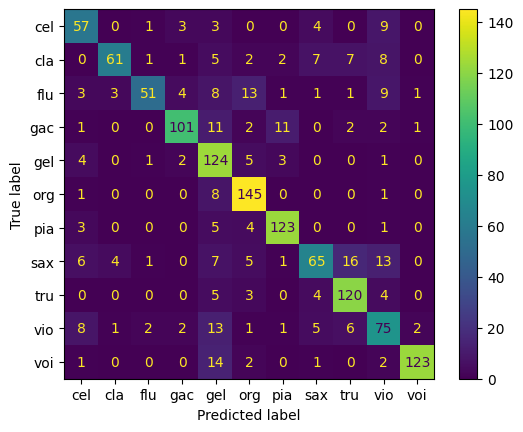

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_preds), display_labels=INS_CODE.keys())
disp.plot()
plt.show()

In [47]:
model = MusicDetectionNet(11).to(device)

dataloader = {
    'train':train_loader,
    'val':val_loader
}
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [46]:
import time
import copy
import torch
def train_model_freeze(model, dataloaders, optimizer, criterion=criterion, num_epochs=20):
    start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_loss_history = []
    val_loss_history = []

    # Freeze all layers except the last one initially
    for param in model.parameters():
        param.requires_grad = False
    for param in model.vgg16.classifier[6].parameters():
        param.requires_grad = True

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # Unfreeze the layers on the 10th epoch
        if epoch == 10:
            print("Unfreezing layers...")
            for param in model.parameters():
                param.requires_grad = True

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0
            for x_batch, y_batch in dataloaders[phase]:
                inputs, labels = x_batch, y_batch
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history, train_loss_history, val_loss_history


In [48]:
model, val_acc_history, train_loss_history, val_loss_history = train_model_freeze(model, dataloader, optimizer, criterion, 20)

Epoch 0/19
----------
train Loss: 2.2874 Acc: 0.1886
val Loss: 2.1562 Acc: 0.2966
Epoch 1/19
----------
train Loss: 2.0813 Acc: 0.3000
val Loss: 2.0413 Acc: 0.3398
Epoch 2/19
----------
train Loss: 1.9862 Acc: 0.3348
val Loss: 1.9736 Acc: 0.3666
Epoch 3/19
----------
train Loss: 1.9273 Acc: 0.3580
val Loss: 1.9313 Acc: 0.3785
Epoch 4/19
----------
train Loss: 1.8747 Acc: 0.3695
val Loss: 1.9020 Acc: 0.3890
Epoch 5/19
----------
train Loss: 1.8335 Acc: 0.3844
val Loss: 1.8703 Acc: 0.3979
Epoch 6/19
----------
train Loss: 1.8141 Acc: 0.3974
val Loss: 1.8437 Acc: 0.4098
Epoch 7/19
----------
train Loss: 1.7926 Acc: 0.3985
val Loss: 1.8234 Acc: 0.4039
Epoch 8/19
----------
train Loss: 1.7616 Acc: 0.4117
val Loss: 1.8091 Acc: 0.4113
Epoch 9/19
----------
train Loss: 1.7482 Acc: 0.4164
val Loss: 1.7922 Acc: 0.4247
Epoch 10/19
----------
Unfreezing layers...
train Loss: 1.5876 Acc: 0.4647
val Loss: 1.3554 Acc: 0.5261
Epoch 11/19
----------
train Loss: 1.0533 Acc: 0.6469
val Loss: 1.3028 Acc: 

In [42]:
all_labels, all_preds = test_model(model, test_loader)

In [41]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.43      0.27      0.33        77
           1       0.47      0.40      0.43        94
           2       0.40      0.26      0.32        95
           3       0.61      0.45      0.52       131
           4       0.44      0.46      0.45       140
           5       0.54      0.63      0.58       155
           6       0.47      0.64      0.54       136
           7       0.38      0.18      0.24       118
           8       0.50      0.38      0.43       136
           9       0.34      0.45      0.39       116
          10       0.50      0.79      0.61       143

    accuracy                           0.47      1341
   macro avg       0.46      0.45      0.44      1341
weighted avg       0.47      0.47      0.45      1341



In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(all_labels, all_preds, average='macro'))
print(recall_score(all_labels, all_preds, average='macro'))
print(f1_score(all_labels, all_preds, average='macro'))

0.46086695207305955
0.44646188399890563
0.44000891919705687


In [44]:
from sklearn.metrics import accuracy_score
print(accuracy_score(all_labels, all_preds))

0.4690529455630127


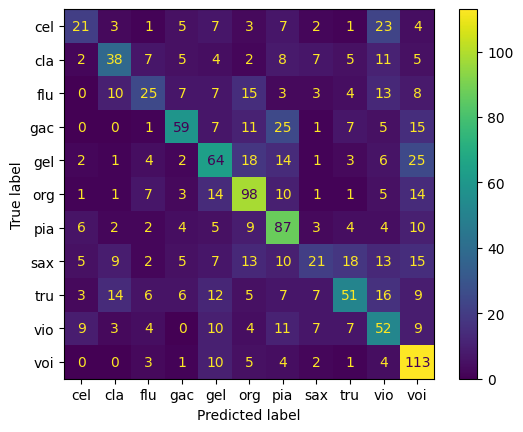

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_preds), display_labels=INS_CODE.keys())
disp.plot()
plt.show()

In [ ]:
plot_training_history(train_loss_history, val_loss_history)